In [1]:
import fasttext.util
fasttext.util.download_model('es', if_exists='ignore')

'cc.es.300.bin'

In [6]:
import fasttext
import fasttext.util

# Load FastText models
iskonawa_model = fasttext.load_model("../../../O3/models/fasttext_model.bin")
spanish_model = fasttext.load_model("cc.es.300.bin")  # Pretrained Spanish FastText
# fasttext.util.reduce_model(spanish_model, 100)


In [7]:
import numpy as np

def get_word_embeddings(word_list, fasttext_model, delimiters=[".", "_"], aggregation_method="sum"):
    """
    Retrieve embeddings for a list of words or composed phrases.
    
    Args:
        word_list (list): List of words or composed phrases (e.g., "agua.del.río").
        fasttext_model: Trained FastText model.
        delimiters (list): Delimiters to split composed words.
        aggregation_method (str): Aggregation method for composed words. Options: "sum", "mean".
    
    Returns:
        np.ndarray: Matrix of word embeddings.
    """
    embeddings = []
    
    for word in word_list:
        # Split composed words using specified delimiters
        for delimiter in delimiters:
            if delimiter in word:
                subwords = word.split(delimiter)
                break
        else:
            subwords = [word]  # Treat as a single word if no delimiter is found
        
        # Get embeddings for subwords
        subword_embeddings = [fasttext_model.get_word_vector(subword) for subword in subwords]
        
        # Aggregate embeddings
        if aggregation_method == "sum":
            word_embedding = np.sum(subword_embeddings, axis=0)
        elif aggregation_method == "mean":
            word_embedding = np.mean(subword_embeddings, axis=0)
        else:
            raise ValueError(f"Unsupported aggregation method: {aggregation_method}")
        
        embeddings.append(word_embedding)
    
    return np.array(embeddings)


In [8]:
import numpy as np
from sklearn.linear_model import Ridge

def learn_mapping(X_src, Y_tgt, regularization=1e-3):
    """
    Learn a mapping from source to target embedding space, handling different dimensions.
    
    Args:
        X_src (np.ndarray): Source embeddings (e.g., Iskonawa) of shape (n_samples, src_dim).
        Y_tgt (np.ndarray): Target embeddings (e.g., Spanish) of shape (n_samples, tgt_dim).
        regularization (float): Regularization parameter for Ridge regression.
    
    Returns:
        np.ndarray: Mapping matrix of shape (src_dim, tgt_dim).
    """
    src_dim = X_src.shape[1]
    tgt_dim = Y_tgt.shape[1]
    
    # Ridge regression to learn mapping
    regressor = Ridge(alpha=regularization, fit_intercept=False)
    regressor.fit(X_src, Y_tgt)
    
    # Mapping matrix (src_dim, tgt_dim)
    mapping_matrix = regressor.coef_.T  # Ridge outputs target_dim x src_dim; transpose for src_dim x tgt_dim
    
    return mapping_matrix


In [9]:
import numpy as np

def learn_generalized_procrustes(X_src, Y_tgt):
    """
    Learn a mapping from source to target embedding space using generalized Procrustes analysis,
    handling different dimensions.

    Args:
        X_src (np.ndarray): Source embeddings (e.g., Iskonawa) of shape (n_samples, src_dim).
        Y_tgt (np.ndarray): Target embeddings (e.g., Spanish) of shape (n_samples, tgt_dim).

    Returns:
        np.ndarray: Mapping matrix of shape (src_dim, tgt_dim).
    """
    # Compute the cross-covariance matrix
    covariance_matrix = np.dot(X_src.T, Y_tgt)  # Shape: (src_dim, tgt_dim)

    # Perform SVD on the covariance matrix
    U, _, Vt = np.linalg.svd(covariance_matrix, full_matrices=False)
    
    # Compute the mapping matrix
    mapping_matrix = np.dot(U, Vt)  # Shape: (src_dim, tgt_dim)

    print(mapping_matrix.shape)

    return mapping_matrix


In [10]:
def map_embeddings(X_src, mapping_matrix):
    """
    Map source embeddings to the target embedding space.
    
    Args:
        X_src (np.ndarray): Source embeddings of shape (n_samples, src_dim).
        mapping_matrix (np.ndarray): Mapping matrix of shape (src_dim, tgt_dim).
    
    Returns:
        np.ndarray: Mapped embeddings in the target space.
    """
    return np.dot(X_src, mapping_matrix)


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def nearest_neighbors(mapped_src_embeds, tgt_embeds, tgt_words, k=1):
    """
    Find the nearest neighbors in the target space for each source word embedding.
    
    Args:
        mapped_src_embeds (np.ndarray): Source embeddings mapped to the target space.
                                        Shape: (n_source_words, target_dim).
        tgt_embeds (np.ndarray): Target embeddings for all target words. Shape: (n_target_words, target_dim).
        tgt_words (list): List of all target words corresponding to the target embeddings.
        k (int): Number of nearest neighbors to retrieve.
    
    Returns:
        dict: Mapping of source index to a list of (target_word, similarity) tuples.
    """
    # Compute cosine similarity between source and target embeddings
    similarities = cosine_similarity(mapped_src_embeds, tgt_embeds)  # Shape: (n_source_words, n_target_words)
    
    # For each source embedding, find the top-k nearest neighbors
    neighbors = {}
    for src_idx, row in enumerate(similarities):
        # Get the indices of the top-k similarities
        top_k_indices = np.argsort(row)[-k:][::-1]
        neighbors[src_idx] = [
            (tgt_words[idx], row[idx]) for idx in top_k_indices
        ]
    
    return neighbors


In [12]:
import numpy as np

def gpa_two_spaces(src_embeddings, tgt_embeddings, num_iterations=100):
    """
    Generalized Procrustes Analysis (GPA) for two embedding spaces.

    Args:
        src_embeddings (np.ndarray): Source embeddings of shape (n_samples, dim).
        tgt_embeddings (np.ndarray): Target embeddings of shape (n_samples, dim).
        num_iterations (int): Number of iterations for GPA.

    Returns:
        np.ndarray: Shared latent space G.
        np.ndarray: Transformation matrix for source space (T_src).
        np.ndarray: Transformation matrix for target space (T_tgt).
    """
    # Ensure embeddings are the same dimensionality
    assert src_embeddings.shape[1] == tgt_embeddings.shape[1], "Dimensions must match."
    
    dim = src_embeddings.shape[1]
    G = src_embeddings.copy()  # Initialize G with the source embeddings
    T_src, T_tgt = np.eye(dim), np.eye(dim)  # Initialize transformation matrices

    for _ in range(num_iterations):
        # Update transformations
        U_src, _, Vt_src = np.linalg.svd(np.dot(G.T, src_embeddings))
        T_src = np.dot(Vt_src.T, U_src.T)

        U_tgt, _, Vt_tgt = np.linalg.svd(np.dot(G.T, tgt_embeddings))
        T_tgt = np.dot(Vt_tgt.T, U_tgt.T)

        # Update latent space G
        G = (np.dot(src_embeddings, T_src) + np.dot(tgt_embeddings, T_tgt)) / 2

    return G, T_src, T_tgt


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

def train_bdi_pa(seed_dict, src_embeddings, tgt_embeddings, src_words, tgt_words):
    """
    Train a bilingual dictionary induction model.
    
    Args:
        seed_dict (list): List of (source_word, target_word) seed pairs.
        src_embeddings (dict): Precomputed source embeddings (word -> embedding).
        tgt_embeddings (dict): Precomputed target embeddings (word -> embedding).
        src_words (list): List of source words in the vocabulary.
        tgt_words (list): List of target words in the vocabulary.
    
    Returns:
        dict: Nearest neighbors for the test set with top-3 target words.
        float: Precision@3 score on the test set.
    """
    # 1. Prepare seed data
    src_seed = np.array([src_embeddings[pair[0]] for pair in seed_dict])
    tgt_seed = np.array([tgt_embeddings[pair[1]] for pair in seed_dict])
    
    # Split seed pairs into train and test sets (80% for training, 20% for testing)
    train_pairs, test_pairs = train_test_split(seed_dict, test_size=0.2, random_state=42)
    
    # Extract the source and target words from the train and test sets
    train_src_words = [pair[0] for pair in train_pairs]
    test_src_words = [pair[0] for pair in test_pairs]
    train_tgt_words = [pair[1] for pair in train_pairs]
    test_tgt_words = [pair[1] for pair in test_pairs]
    
    # Get the embeddings for the training and test sets
    train_src = np.array([src_embeddings[word] for word in train_src_words])
    test_src = np.array([src_embeddings[word] for word in test_src_words])
    train_tgt = np.array([tgt_embeddings[word] for word in train_tgt_words])
    test_tgt = np.array([tgt_embeddings[word] for word in test_tgt_words])
    
    # 2. Train mapping function using only training data
    # print(train_src)
    mapping = learn_mapping(train_src, train_tgt)
    
    # 3. Test mapping (evaluate on test set)
    mapped_test_src = map_embeddings(test_src, mapping)
    
    # 4. Find nearest neighbors for test source words
    # Now we use all the target embeddings, not just those seen in the training set
    all_tgt_embeds = np.array([tgt_embeddings[word] for word in tgt_words])  # All target embeddings
    test_neighbors = nearest_neighbors(mapped_test_src, all_tgt_embeds, tgt_words, k=10)
    
    # 5. Compute precision at k using the true target words
    test_p_at_3 = precision_at_k(test_neighbors, test_tgt_words, k=10)
    
    # 6. Evaluate on the train set
    mapped_train_src = map_embeddings(train_src, mapping)
    train_neighbors = nearest_neighbors(mapped_train_src, all_tgt_embeds, tgt_words, k=10)
    train_p_at_3 = precision_at_k(train_neighbors, train_tgt_words, k=10)

    # Visualize the train set mapping
    plot_embeddings_side_by_side(train_src, all_tgt_embeds, mapped_train_src, train_src_words, tgt_words)

    # Visualize the test set mapping
    plot_embeddings_side_by_side(test_src, all_tgt_embeds, mapped_test_src, test_src_words, tgt_words)
    
    # Print results
    print(f"Test Precision@3: {test_p_at_3:.4f}")
    print(f"Train Precision@3: {train_p_at_3:.4f}")
    
    return test_neighbors, test_p_at_3

def train_bdi_gpa(seed_dict, src_embeddings, tgt_embeddings, src_words, tgt_words, num_iterations=100):
    """
    Train a bilingual dictionary induction model using GPA.

    Args:
        seed_dict (list): List of (source_word, target_word) seed pairs.
        src_embeddings (dict): Precomputed source embeddings (word -> embedding).
        tgt_embeddings (dict): Precomputed target embeddings (word -> embedding).
        src_words (list): List of source words in the vocabulary.
        tgt_words (list): List of target words in the vocabulary.
        num_iterations (int): Number of iterations for GPA.

    Returns:
        dict: Nearest neighbors for the test set with top-3 target words.
        float: Precision@3 score on the test set.
    """
    # 1. Prepare seed data
    src_seed = np.array([src_embeddings[pair[0]] for pair in seed_dict])
    tgt_seed = np.array([tgt_embeddings[pair[1]] for pair in seed_dict])
    
    # Split seed pairs into train and test sets
    train_pairs, test_pairs = train_test_split(seed_dict, test_size=0.2, random_state=42)
    train_src_words = [pair[0] for pair in train_pairs]
    test_src_words = [pair[0] for pair in test_pairs]
    train_tgt_words = [pair[1] for pair in train_pairs]
    test_tgt_words = [pair[1] for pair in test_pairs]
    
    train_src = np.array([src_embeddings[word] for word in train_src_words])
    test_src = np.array([src_embeddings[word] for word in test_src_words])
    train_tgt = np.array([tgt_embeddings[word] for word in train_tgt_words])
    test_tgt = np.array([tgt_embeddings[word] for word in test_tgt_words])
    
    # 2. Align embeddings using GPA
    G, T_src, T_tgt = gpa_two_spaces(train_src, train_tgt, num_iterations=num_iterations)
    
    # 3. Test mapping (evaluate on test set)
    mapped_test_src = np.dot(test_src, T_src)  # Map test source embeddings
    all_tgt_embeds = np.array([tgt_embeddings[word] for word in tgt_words])
    test_neighbors = nearest_neighbors(mapped_test_src, all_tgt_embeds, tgt_words, k=10)
    
    # 4. Compute precision at k
    test_p_at_3 = precision_at_k(test_neighbors, test_tgt_words, k=10)
    
    # 5. Evaluate on the train set
    mapped_train_src = np.dot(train_src, T_src)  # Map train source embeddings
    train_neighbors = nearest_neighbors(mapped_train_src, all_tgt_embeds, tgt_words, k=10)
    train_p_at_3 = precision_at_k(train_neighbors, train_tgt_words, k=10)
    
    # Print results
    print(f"Test Precision@3: {test_p_at_3:.4f}")
    print(f"Train Precision@3: {train_p_at_3:.4f}")
    
    return test_neighbors, test_p_at_3



def precision_at_k(neighbors, true_targets, k=3):
    """
    Compute precision@k for nearest neighbors in a one-to-one dictionary setting.

    Args:
        neighbors (dict): Nearest neighbors output from `nearest_neighbors`. 
                          Keys are indices, values are lists of (word, similarity).
        true_targets (list): List of true target words for the test set (one-to-one mapping).
        k (int): Number of neighbors considered.

    Returns:
        float: Precision@k score.
    """
    correct = 0
    total = len(neighbors)

    for idx, neighbor_list in neighbors.items():
        # Extract the top-k neighbors' words
        top_k_neighbors = [word for word, _ in neighbor_list[:k]]
        
        # Print the true target and the predicted neighbors for each test case
        true_target_word = true_targets[idx]
        print(f"True target word: {true_target_word}")
        print(f"Predicted neighbors: {top_k_neighbors}")
        
        # Check if the true target word is in the top-k neighbors
        if true_target_word in top_k_neighbors:
            correct += 1

    # Precision@k is the ratio of correct predictions to total predictions
    return correct / total



In [14]:
import random

def load_seed_pairs(file_path, num_pairs=200):
    """
    Load word pairs from a file, randomly select a subset, and return as a list of tuples.
    
    Args:
        file_path (str): Path to the text file containing word pairs.
        num_pairs (int): Number of pairs to select from the file. Default is 200.
    
    Returns:
        list: A list of tuples containing selected (source_word, target_word) pairs.
    """
    # Read the file and load word pairs
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Process the lines to get the word pairs
    word_pairs = [line.strip().split(":") for line in lines if ":" in line]
    
    # Randomly select num_pairs word pairs from the list
    selected_pairs = random.sample(word_pairs, num_pairs)
    
    return selected_pairs

# Example usage:
file_path = 'word_pairs.txt'  # Update with your file path
seed_dict = load_seed_pairs(file_path, num_pairs=200)


In [10]:
len(seed_dict)

200

In [19]:
def load_embeddings(model, word_list, delimiters=[".", "_"], aggregation_method="sum"):
    """
    Load word embeddings from a FastText model for a list of words or composed phrases.
    
    Args:
        fasttext_model_path (str): Path to the FastText model.
        word_list (list): List of words or composed phrases (e.g., "agua.del.río").
        delimiters (list): Delimiters to split composed words.
        aggregation_method (str): Aggregation method for composed words. Options: "sum", "mean".
    
    Returns:
        dict: Word -> embedding mapping.
    """
    embeddings = {}
    for word in word_list:
        embeddings[word] = get_word_embeddings([word], model, delimiters, aggregation_method)[0]
    return embeddings

### w2v

In [26]:
import sentencepiece as spm
from gensim.models import Word2Vec
# Load BPE model
sp_bpe = spm.SentencePieceProcessor()
sp_bpe.load("../tokenizer/spbpe_isc_1000.model")
def tokenize_with_bpe(sp_bpe, words):
    bpe_tokenized = []
    for word in words:
        tokens = sp_bpe.encode(word, out_type=str)  # Adjust output type as needed
        bpe_tokenized.extend(tokens)  # Join tokens with space
    return bpe_tokenized

w2v_bpe = Word2Vec.load("../word2vec/iscbpe2vec.model")

In [40]:
# segment the words using BPE
words_bpe = {word: tokenize_with_bpe(sp_bpe, word.split()) for word in src_words}

# obtain the vectors for each subword and average them to get the vector for the word
embeddings = {}
from gensim.matutils import unitvec

def find_closest_vector(subword):
    # Fallback to closest key in the vocabulary
    similar_key, _ = w2v_bpe.wv.most_similar(positive=[unitvec(np.random.random(w2v_bpe.vector_size))], topn=1)[0]
    return w2v_bpe.wv[similar_key]

for word, subwords in words_bpe.items():
    embeddings_list = [
        w2v_bpe.wv[subword] if subword in w2v_bpe.wv else find_closest_vector(subword)
        for subword in subwords
    ]
    embeddings[word] = np.sum(embeddings_list, axis=0)



In [41]:
embeddings

{'chonchon': array([ 0.04023355,  0.08790974, -0.01948961,  0.04397284, -0.00036242,
        -0.09723357,  0.07898009,  0.22574653,  0.01222798, -0.0332134 ,
        -0.02750129, -0.08854163,  0.01925517, -0.07718095, -0.05524706,
        -0.06790338,  0.00881901,  0.00631013,  0.03918774, -0.05384262,
        -0.06115249, -0.02073145,  0.07333098, -0.03545194,  0.05458899,
         0.0500788 , -0.11841189, -0.01668002, -0.06210654, -0.09585964,
         0.02283429, -0.06157552, -0.03032177, -0.01069273, -0.02299437,
         0.03707461,  0.01835524, -0.09737112,  0.02772753, -0.03886747,
        -0.03657338,  0.01544822,  0.06013972, -0.07791966,  0.06508314,
         0.12171241,  0.03575462,  0.01099174, -0.03348087,  0.1093246 ,
         0.06174726,  0.05298287, -0.00872582,  0.0265855 , -0.0286569 ,
         0.14534535,  0.06139548, -0.01268539,  0.03040527, -0.02490334,
        -0.04167155, -0.04688432, -0.01747813,  0.02301674,  0.03062721,
         0.04756321, -0.01086225,  0.01

### morfessor

In [48]:
from morfessor import BaselineModel, MorfessorIO
from gensim.models import Word2Vec
io_handler = MorfessorIO()
model = io_handler.read_binary_model_file('../morfessor/morf_isc_model.bin')
def segment_words(model, words):
    segmented_words = []
    for word in words:
        try:
            # Try to segment the word using the model analyses
            segments = model.segment(word)
        except KeyError:
            # If the word is not in the training data, use viterbi_segment
            segments = model.viterbi_segment(word)[0]
        segmented_words.extend(segments)  
    return segmented_words

w2v_morf = Word2Vec.load("../word2vec/iscmorf2vec.model")

In [50]:
# segment the words using BPE
words_morf = {word: segment_words(model, word.split()) for word in src_words}

# obtain the vectors for each subword and average them to get the vector for the word
embeddings = {}

for word, subwords in words_morf.items():
    embeddings_list = [
        w2v_morf.wv[subword] if subword in w2v_morf.wv else find_closest_vector(subword)
        for subword in subwords
    ]
    embeddings[word] = np.sum(embeddings_list, axis=0)



In [51]:
embeddings

{'chonchon': array([-5.59529755e-04,  7.46412575e-02,  1.54583091e-02,  6.55453559e-03,
         6.22485811e-03, -5.49408160e-02,  4.73793484e-02,  1.36910513e-01,
         1.40567888e-02, -1.97649803e-02,  1.13136284e-02, -7.17314631e-02,
         1.53193502e-02,  1.04450691e-03, -4.01341952e-02, -3.83312162e-03,
         2.85727885e-02, -2.82110670e-03,  4.69536595e-02, -3.69771682e-02,
        -2.99423914e-02, -4.04409366e-03,  2.44686771e-02, -1.66858896e-03,
         1.17954174e-02, -1.06490338e-02, -2.78748926e-02, -9.59760044e-03,
        -7.52161071e-02, -3.25084403e-02,  3.04779448e-02, -5.24153411e-02,
         3.18582878e-02,  2.37491261e-02, -9.76355094e-03,  2.42107678e-02,
         1.31908488e-02, -4.59164716e-02, -1.87260862e-02, -1.26982434e-02,
         1.29708378e-02,  3.94652784e-02,  7.99959339e-03, -4.89588231e-02,
         5.85849471e-02,  8.88808817e-02,  6.75108889e-03,  1.17697920e-04,
        -1.07349511e-02,  1.88458953e-02,  2.43918020e-02,  5.56015037e-03,


### mbert

In [3]:
from transformers import BertForMaskedLM, BertTokenizer
import sentencepiece as spm

# Load the trained model and tokenizer
model = BertForMaskedLM.from_pretrained("../mBERT/mbert_BPE", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("../mBERT/mbert_BPE")

sp_bpe = spm.SentencePieceProcessor()
sp_bpe.load("../tokenizer/spbpe_isc_1000.model")

True

In [35]:
import torch
import torch.nn as nn

# Initialize the linear transformation to reduce dimensions
reduction_layer = nn.Linear(in_features=model.config.hidden_size, out_features=300)

def get_word_embedding_with_bpe(model, tokenizer, word, bpe_tokenizer, aggregation_method="sum", reduction_layer=None):
    """
    Get the embedding for a single word, segmented with BPE, and reduce dimensions to 300.
    
    Args:
        model: Pretrained model used for embeddings.
        tokenizer: Tokenizer corresponding to the model.
        word (str): The word to be embedded.
        bpe_tokenizer: SentencePiece or BPE tokenizer for segmentation.
        aggregation_method (str): Method to aggregate subword embeddings.
                                  Options: "mean" (default), "sum", "max".
        reduction_layer (nn.Linear): Linear layer to reduce dimensions (optional).
    
    Returns:
        torch.Tensor: Aggregated embedding for the input word with reduced dimensions.
    """
    # Segment the word into subwords using BPE
    bpe_subwords = bpe_tokenizer.encode(word, out_type=str)  # Segment using BPE
    segmented_word = " ".join(bpe_subwords)  # Join subwords into a single string

    # Tokenize the segmented word for the model
    inputs = tokenizer(segmented_word, return_tensors="pt", truncation=True)
    
    with torch.no_grad():
        # Get model outputs
        outputs = model(**inputs)
    
    # Extract hidden states (last layer)
    hidden_states = outputs.hidden_states[-1]  # Shape: (batch_size, seq_length, hidden_dim)

    # Remove batch dimension
    subword_embeddings = hidden_states.squeeze(0)  # Shape: (num_subwords, hidden_dim)
    
    # Aggregate subword embeddings
    if aggregation_method == "mean":
        word_embedding = subword_embeddings.mean(dim=0)  # Average pooling
    elif aggregation_method == "sum":
        word_embedding = subword_embeddings.sum(dim=0)  # Sum pooling
    elif aggregation_method == "max":
        word_embedding, _ = subword_embeddings.max(dim=0)  # Max pooling
    else:
        raise ValueError(f"Unsupported aggregation method: {aggregation_method}")
    
    # Apply dimensionality reduction if reduction_layer is provided
    if reduction_layer is not None:
        word_embedding = reduction_layer(word_embedding)
    
    return word_embedding.detach().numpy()


In [36]:
# obtain the vectors for each subword and average them to get the vector for the word
embeddings = {}

for word in src_words:
    embeddings[word] = get_word_embedding_with_bpe(model=model,tokenizer=tokenizer, word=word, bpe_tokenizer=sp_bpe, reduction_layer=reduction_layer)

## continuar

In [15]:
# Assuming you have a list of all source and target words (vocab) in your languages
src_words = [pair[0] for pair in seed_dict]
tgt_words = [pair[1] for pair in seed_dict]


In [38]:

# Load precomputed embeddings for both source and target words
# src_embeddings = load_embeddings(iskonawa_model, src_words)
src_embeddings = embeddings
tgt_embeddings = load_embeddings(spanish_model, tgt_words)


In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings_with_pca(embeddings, title="Embedding Visualization"):
    """
    Plot embeddings after reducing their dimensionality using PCA.
    
    Args:
        embeddings (np.ndarray): Embedding vectors (shape: [n_samples, n_features]).
        title (str): Title of the plot.
    """
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Plot the embeddings
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6)
    
    # Add title and labels
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


In [39]:
# Assuming `embeddings_dict` is your dictionary containing the embeddings
embeddings_list = list(src_embeddings.values())


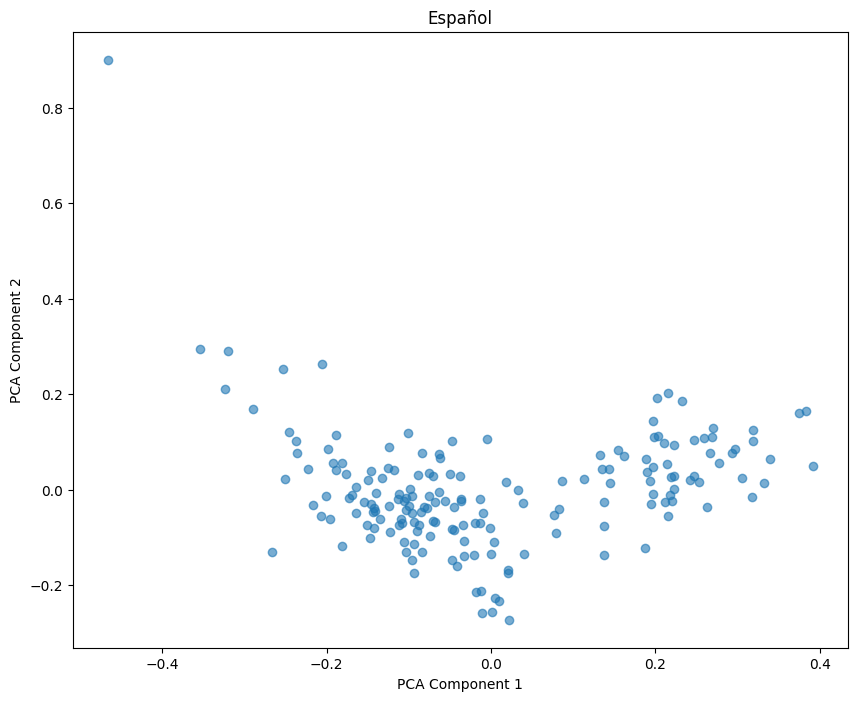

In [23]:
plot_embeddings_with_pca(embeddings_list, "Español")

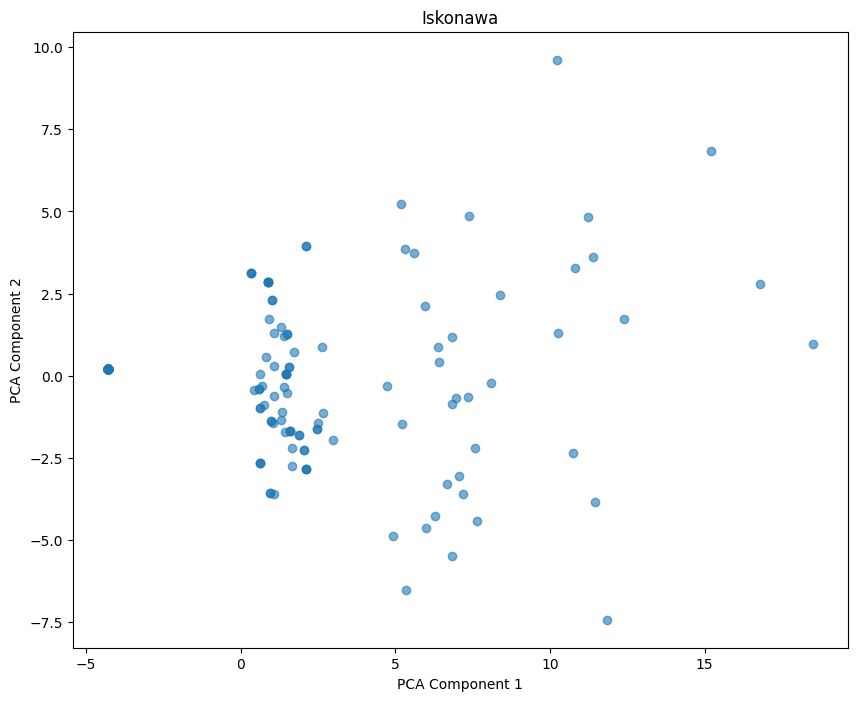

In [40]:
plot_embeddings_with_pca(embeddings_list, "Iskonawa")

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

def train_bdi_iterative_with_split(seed_dict, src_embeddings, tgt_embeddings, src_words, tgt_words, initial_pairs=200, batch_size=200, test_size=0.2):
    """
    Train a bilingual dictionary induction model with iterative refinement and train-test split.
    
    Args:
        seed_dict (list): List of all (source_word, target_word) pairs.
        src_embeddings (dict): Precomputed source embeddings (word -> embedding).
        tgt_embeddings (dict): Precomputed target embeddings (word -> embedding).
        src_words (list): List of source words in the vocabulary.
        tgt_words (list): List of target words in the vocabulary.
        initial_pairs (int): Number of initial seed pairs to start with.
        batch_size (int): Number of new pairs to add in each iteration.
        test_size (float): Proportion of the data to use as a test set in each iteration.
    
    Returns:
        list: Metrics for each iteration, including test precision@k.
    """
    remaining_pairs = seed_dict[:]
    metrics = []

    # Iteratively train and evaluate
    iteration = 0
    while len(remaining_pairs) >= initial_pairs:
        iteration += 1
        
        # Split current seed into train and test sets
        current_train, current_test = train_test_split(
            remaining_pairs[:initial_pairs], test_size=test_size, random_state=iteration
        )
        # Extract train and test embeddings
        train_src_words = [pair[0] for pair in current_train]
        train_tgt_words = [pair[1] for pair in current_train]
        train_src = np.array([src_embeddings[word] for word in train_src_words])
        train_tgt = np.array([tgt_embeddings[word] for word in train_tgt_words])
        
        test_src_words = [pair[0] for pair in current_test]
        test_tgt_words = [pair[1] for pair in current_test]
        test_src = np.array([src_embeddings[word] for word in test_src_words])
        test_tgt = np.array([tgt_embeddings[word] for word in test_tgt_words])
        
        # Train mapping function
        mapping = learn_generalized_procrustes(train_src, train_tgt)
        
        # Map test embeddings
        mapped_test_src = map_embeddings(test_src, mapping)
        
        # Evaluate nearest neighbors
        all_tgt_embeds = np.array([tgt_embeddings[word] for word in tgt_words])
        test_neighbors = nearest_neighbors(mapped_test_src, all_tgt_embeds, tgt_words, k=10)
        test_p_at_3 = precision_at_k(test_neighbors, test_tgt_words, k=10)
        
        # Add metrics for this iteration
        metrics.append({
            'iteration': iteration,
            'test_precision_at_3': test_p_at_3,
            'train_size': len(current_train),
            'test_size': len(current_test)
        })
        
        # Print iteration results
        print(f"Iteration {iteration}: Train size = {len(current_train)}, Test size = {len(current_test)}, Test Precision@3 = {test_p_at_3:.4f}")
        
        # Update remaining pairs: Move current test set into next train set
        next_batch_start = min(len(remaining_pairs), initial_pairs + batch_size)
        remaining_pairs = current_test + remaining_pairs[next_batch_start:]
    
    # Return metrics for all iterations
    return metrics


In [125]:
metrics

[{'iteration': 1,
  'test_precision_at_3': 0.025,
  'train_size': 160,
  'test_size': 40}]

/home/atrujillo/langmodels/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=8.88886e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


True target word:  poner
Predicted neighbors: [' cantar', ' servir', ' molestarse', ' colocar', ' insistir', ' engañar', ' pensar', ' golpear', ' soplar', ' soplar']
True target word:  cuento
Predicted neighbors: [' copaiba', ' bastón', ' concha', ' plátano', ' algodón', ' yuca', ' ishpingo', ' cedro', ' cedro', ' papaya']
True target word:  tía
Predicted neighbors: [' cocha', ' cocido', ' yuca', ' parrilla', ' parrilla', ' papaya', ' tortilla', ' ella', ' ella', ' roca']
True target word:  asar
Predicted neighbors: [' cantar', ' soplar', ' soplar', ' insistir', ' desatar', ' asar', ' trabajar', ' aumentar', ' renegar', ' poner']
True target word:  ahí
Predicted neighbors: [' matar', ' cantar', ' correr', ' encender', ' pudrirse', ' poner', ' insistir', ' ella', ' ella', ' engañar']
True target word:  comida
Predicted neighbors: [' matar', ' cantar', ' correr', ' encender', ' pudrirse', ' poner', ' insistir', ' ella', ' ella', ' engañar']
True target word:  ahí
Predicted neighbors: [' 

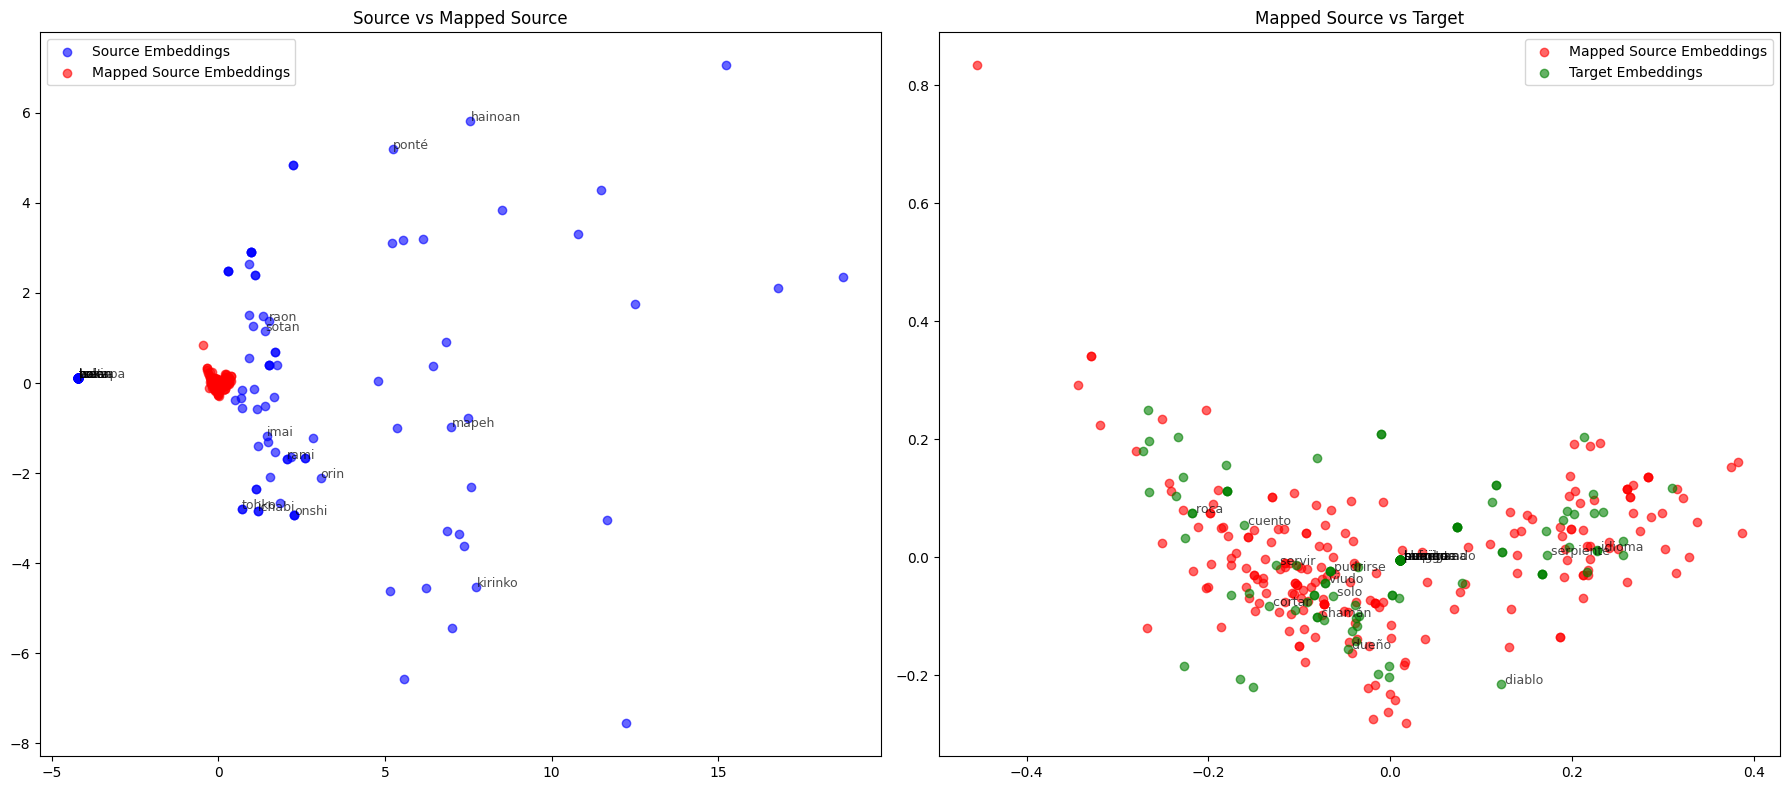

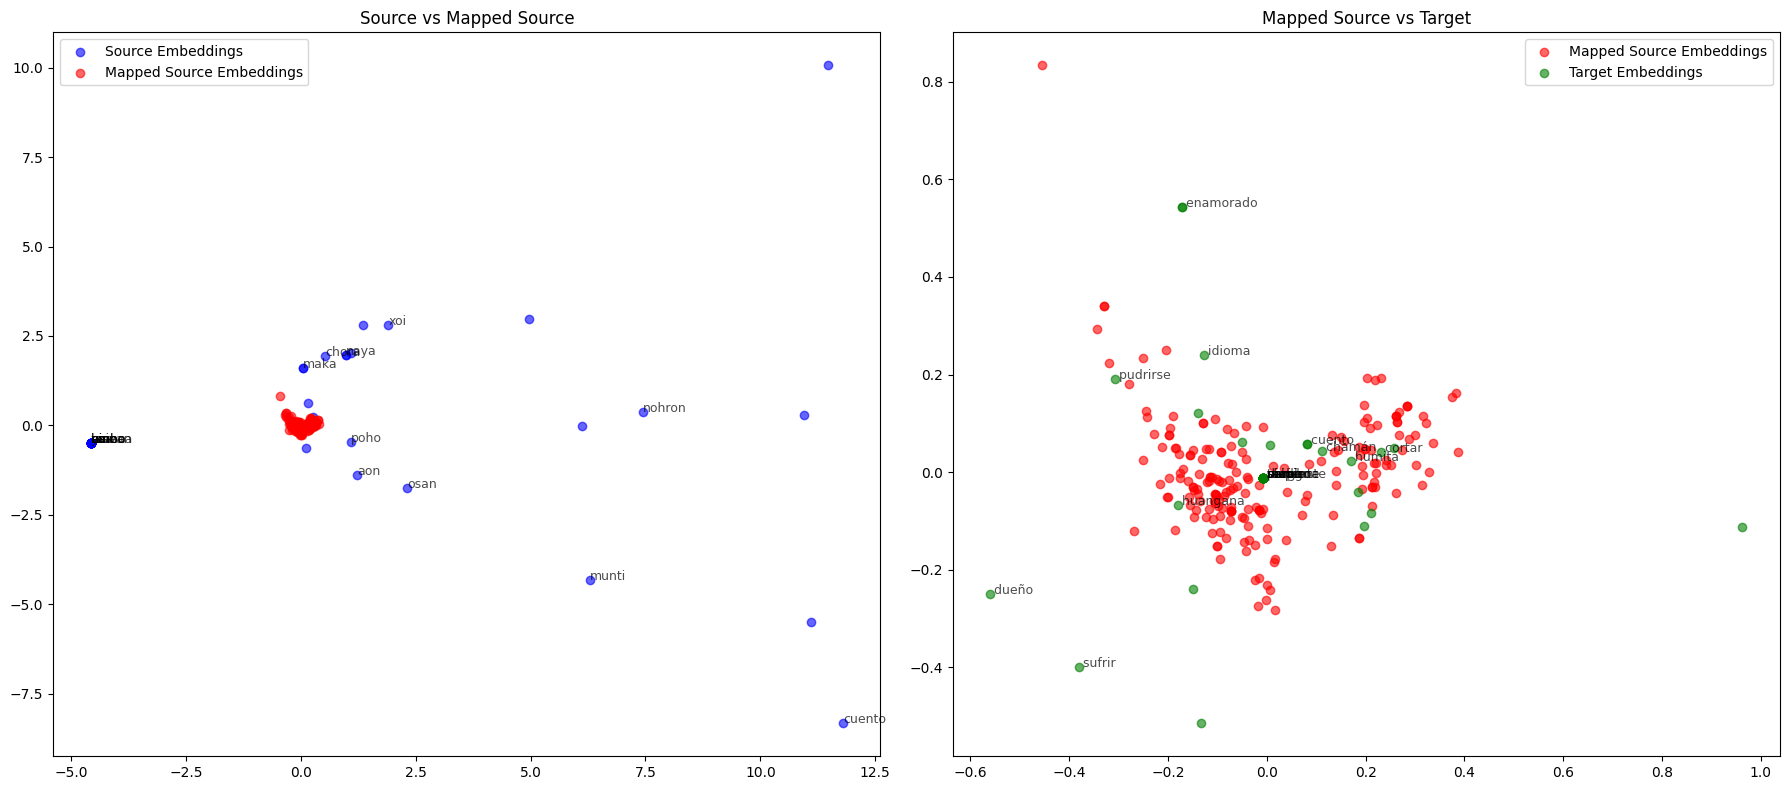

Test Precision@3: 0.0500
Train Precision@3: 0.5312
Test Precision@3: 0.0500


In [43]:

# Train the BDI model
test_neighbors, test_p_at_3 = train_bdi_pa(seed_dict, src_embeddings, tgt_embeddings, src_words, tgt_words)

# Output the nearest neighbors and Precision@3 score
# print("Test Nearest Neighbors:", test_neighbors)
print(f"Test Precision@3: {test_p_at_3:.4f}")

In [28]:
metrics = train_bdi_iterative_with_split(
    seed_dict, src_embeddings, tgt_embeddings, src_words, tgt_words, initial_pairs=200, batch_size=100, test_size=0.2
)

(100, 100)
True target word:  nuevo
Predicted neighbors: [' gordo', ' pudrirse', ' hueco', ' tazón.grande', ' tocar.algo.caliente', ' rabioso', ' oler', ' mano', ' suyo', ' suyo']
True target word:  echar
Predicted neighbors: [' bajar', ' pasar.por.debajo', ' ahora', ' amarrar', ' otro.lado', ' atizar', ' abrir.piernas', ' pijuayo', ' colgar', ' cortar.con.sierra']
True target word:  engañar
Predicted neighbors: [' algodón', ' loro', ' plátano', ' plátano', ' faltar', ' maíz', ' maíz', ' chapear', ' bambú', ' colgar']
True target word:  dar
Predicted neighbors: [' faltar', ' crecer', ' correr', ' colgar', ' enroscarse', ' tazón.grande', ' batán', ' pudrirse', ' volar', ' jalar']
True target word:  tocar.algo.caliente
Predicted neighbors: [' pudrirse', ' calmarse', ' dejar', ' morir', ' hablar', ' llenarse', ' llenar', ' llenar', ' matar', ' echarse']
True target word:  olor
Predicted neighbors: [' hablar', ' moler', ' soplar', ' matar', ' correr', ' echar', ' cavar', ' llorar', ' poner

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to reduce dimensionality using PCA or t-SNE
def plot_embeddings(src_embeddings, mapped_tgt_embeddings, tgt_embeddings, src_words, tgt_words, title="Embedding Visualization"):
    # Apply PCA or t-SNE for dimensionality reduction
    pca = PCA(n_components=2)
    src_2d = pca.fit_transform(src_embeddings)
    mapped_tgt_2d = pca.fit_transform(mapped_tgt_embeddings)
    tgt_2d = pca.fit_transform(tgt_embeddings)

    # Plotting the source and target embeddings
    plt.figure(figsize=(10, 8))
    plt.scatter(src_2d[:, 0], src_2d[:, 1], c='blue', label='Source Embeddings')
    plt.scatter(mapped_tgt_2d[:, 0], mapped_tgt_2d[:, 1], c='red', label='Mapped Target Embeddings')
    plt.scatter(tgt_2d[:, 0], tgt_2d[:, 1], c='green', label='Target Embeddings')

    # Adding labels for some of the points
    for i, word in enumerate(src_words[:20]):  # Limiting to first 20 for clarity
        plt.annotate(word, (src_2d[i, 0], src_2d[i, 1]))
    for i, word in enumerate(tgt_words[:20]):
        plt.annotate(word, (tgt_2d[i, 0], tgt_2d[i, 1]))
    
    plt.legend()
    plt.title(title)
    plt.show()

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings_side_by_side(
    src_embeddings, mapped_src_embeddings, tgt_embeddings, 
    src_words, tgt_words, title1="Source vs Mapped Source", title2="Mapped Source vs Target"
):
    """
    Plot two graphs side by side:
    1. Source embeddings and mapped source embeddings.
    2. Mapped source embeddings and target embeddings.
    
    Args:
        src_embeddings (np.ndarray): Source embeddings.
        mapped_src_embeddings (np.ndarray): Mapped source embeddings.
        tgt_embeddings (np.ndarray): Target embeddings.
        src_words (list): Source words.
        tgt_words (list): Target words.
        title1 (str): Title for the first plot.
        title2 (str): Title for the second plot.
    """
    # Apply PCA independently to each embedding space
    src_pca = PCA(n_components=2).fit_transform(src_embeddings)
    mapped_src_pca = PCA(n_components=2).fit_transform(mapped_src_embeddings)
    tgt_pca = PCA(n_components=2).fit_transform(tgt_embeddings)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Source vs Mapped Source Embeddings
    axes[0].scatter(src_pca[:, 0], src_pca[:, 1], c='blue', label='Source Embeddings', alpha=0.6)
    axes[0].scatter(mapped_src_pca[:, 0], mapped_src_pca[:, 1], c='red', label='Mapped Source Embeddings', alpha=0.6)
    for i, word in enumerate(src_words[:20]):  # Annotate first 20 words
        axes[0].annotate(word, (src_pca[i, 0], src_pca[i, 1]), fontsize=9, alpha=0.7)
    axes[0].set_title(title1)
    axes[0].legend()
    
    # Plot 2: Mapped Source vs Target Embeddings
    axes[1].scatter(mapped_src_pca[:, 0], mapped_src_pca[:, 1], c='red', label='Mapped Source Embeddings', alpha=0.6)
    axes[1].scatter(tgt_pca[:, 0], tgt_pca[:, 1], c='green', label='Target Embeddings', alpha=0.6)
    for i, word in enumerate(tgt_words[:20]):  # Annotate first 20 words
        axes[1].annotate(word, (tgt_pca[i, 0], tgt_pca[i, 1]), fontsize=9, alpha=0.7)
    axes[1].set_title(title2)
    axes[1].legend()
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()



def visualize_mapped_embeddings(src_embeddings, tgt_embeddings, mapped_tgt_embeddings, src_words, tgt_words):
    """
    Visualize embeddings using PCA or t-SNE.
    
    Arguments:
    - src_embeddings: Source embeddings (numpy array)
    - tgt_embeddings: Target embeddings (numpy array)
    - mapped_tgt_embeddings: Target embeddings after mapping (numpy array)
    - src_words: List of source words (for labeling)
    - tgt_words: List of target words (for labeling)
    """
    plot_embeddings(src_embeddings, mapped_tgt_embeddings, tgt_embeddings, src_words, tgt_words, "Mapped Embeddings Visualization")
    # plot_embeddings_side_by_side(src_embeddings, mapped_tgt_embeddings, tgt_embeddings, src_words, tgt_words)


